This notebook contains code for traning a RandomForest regressor to predict measurement biases of miRXplore datasets from TGIRT-seq.

The [R RandomForest](https://cran.r-project.org/web/packages/randomForest/randomForest.pdf) model is being used here becuase neither [scikit-learn randomforest](https://github.com/scikit-learn/scikit-learn/issues/5442) nor the *train* module from [caret](https://stats.stackexchange.com/questions/135671/how-does-caret-handle-factors) can handle categorically-labeled data.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold, train_test_split
import seaborn as sns
from sequencing_tools.viz_tools import color_encoder, simpsons_palette, mixed_sort
from helper_function import *
from feature_selection import make_pca_df, pca_biplot, loading_plot
from rf_modeling import h2o_randomForest, R_randomForest, test_nucleotides, train_to_cat,\
                        rename_col, k_fold_cv, plot_kfold_reg, plot_var,\
                        plot_R2, plot_test
from rpy2.robjects import pandas2ri

plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)

/Users/wckdouglas/miniconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_152-release"; OpenJDK Runtime Environment (build 1.8.0_152-release-1056-b12); OpenJDK 64-Bit Server VM (build 25.152-b12, mixed mode)
  Starting server from /Users/wckdouglas/miniconda3/h2o_jar/h2o.jar
  Ice root: /var/folders/g8/zz6rn1j56m1fst5c66p2wxk40000gn/T/tmplcl3a8ax
  JVM stdout: /var/folders/g8/zz6rn1j56m1fst5c66p2wxk40000gn/T/tmplcl3a8ax/h2o_wckdouglas_started_from_python.out
  JVM stderr: /var/folders/g8/zz6rn1j56m1fst5c66p2wxk40000gn/T/tmplcl3a8ax/h2o_wckdouglas_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,05 secs
H2O cluster timezone:,America/Chicago
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.2
H2O cluster version age:,8 months and 9 days !!!
H2O cluster name:,H2O_from_python_wckdouglas_5xb4c8
H2O cluster total nodes:,1
H2O cluster free memory:,3.556 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


Reading in miRNA count data, combining counts from replicates and only look at NTT data, the first and last 3 nucleotides of each miRNA are extracted as predictors, $\Delta log10$ CPM is computed and will be used as target:

In [2]:
df = pd.read_csv('../data/miR_count.csv') \
    .groupby(["prep","seq_id"], as_index=False) \
    .agg({'seq_count':'sum'})\
    .merge(get_seq_base(shuffle = [0,1,2,-3,-2,-1]))\
    .assign(cpm = lambda d: d.groupby('prep').seq_count.transform(count_to_cpm))\
    .assign(expected_cpm = lambda d: 1e6 / 962) \
    .assign(Y = lambda d: np.log10(d['cpm']) - np.log10(d['expected_cpm']))  \
    .query('prep == "NTT"')\
    .reset_index() \
    .drop('index', axis=1)
df.head()

,prep,seq_id,seq_count,head0,head1,head2,tail0,tail1,tail2,cpm,expected_cpm,Y
0,NTT,EBV-1-1,401,T,A,A,G,T,T,11.747525,1039.50104,-1.946879
1,NTT,EBV-1-2,42861,T,A,T,T,G,A,1255.637604,1039.50104,0.082039
2,NTT,EBV-1-2-star,2508,A,A,A,A,G,C,73.473300,1039.50104,-1.150695
3,NTT,EBV-1-3,3964,T,A,A,A,C,A,116.127656,1039.50104,-0.951889
4,NTT,EBV-1-3P,3684,T,A,G,G,T,C,107.924895,1039.50104,-0.983703


In [3]:
control_df = pd.read_csv('../data/miR_count.csv') \
    .groupby(["prep","seq_id"], as_index=False) \
    .agg({'seq_count':'sum'})\
    .merge(get_seq_base(shuffle = [3,4,5,-6,-5,-4]))\
    .assign(cpm = lambda d: d.groupby('prep').seq_count.transform(count_to_cpm))\
    .assign(expected_cpm = lambda d: 1e6 / 962) \
    .assign(Y = lambda d: np.log10(d['cpm']) - np.log10(d['expected_cpm']))  \
    .query('prep == "NTT"')\
    .reset_index() \
    .drop('index', axis=1)
control_df.head()

,prep,seq_id,seq_count,head0,head1,head2,tail0,tail1,tail2,cpm,expected_cpm,Y
0,NTT,EBV-1-1,401,C,C,T,G,G,A,11.747525,1039.50104,-1.946879
1,NTT,EBV-1-2,42861,C,T,T,A,A,T,1255.637604,1039.50104,0.082039
2,NTT,EBV-1-2-star,2508,T,T,C,G,A,T,73.473300,1039.50104,-1.150695
3,NTT,EBV-1-3,3964,C,G,G,A,G,C,116.127656,1039.50104,-0.951889
4,NTT,EBV-1-3P,3684,C,A,C,T,A,T,107.924895,1039.50104,-0.983703


In [4]:
model_df = df.filter(regex = 'head|tail|Y') \
    .pipe(train_to_cat)
model_df.head()

/Users/wckdouglas/Google_Drive/Lab/projects/miRNA/tgirt_smRNA/scripts/rf_modeling.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  d[col] = d[col].astype('category')


,head0,head1,head2,tail0,tail1,tail2,Y
0,T,A,A,G,T,T,-1.946879
1,T,A,T,T,G,A,0.082039
2,A,A,A,A,G,C,-1.150695
3,T,A,A,A,C,A,-0.951889
4,T,A,G,G,T,C,-0.983703


In [5]:
control_model_df = control_df.filter(regex = 'head|tail|Y') \
    .pipe(train_to_cat)
control_model_df.head()

/Users/wckdouglas/Google_Drive/Lab/projects/miRNA/tgirt_smRNA/scripts/rf_modeling.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  d[col] = d[col].astype('category')


,head0,head1,head2,tail0,tail1,tail2,Y
0,C,C,T,G,G,A,-1.946879
1,C,T,T,A,A,T,0.082039
2,T,T,C,G,A,T,-1.150695
3,C,G,G,A,G,C,-0.951889
4,C,A,C,T,A,T,-0.983703


# K-fold cross-validation #

20% of the data is partitioned out as test set, other 80% goes into an 8-fold cross-validation

In [6]:
train_df, test_df = train_test_split(model_df, test_size=0.2, random_state=123)
control_train_df, control_test_df = train_test_split(control_model_df, test_size=0.2, random_state=123)

Collect predictions and variable importances from each fold 

In [7]:
res_df, var_df, test_df = k_fold_cv(train_df, test_df)
control_res_df, control_var_df, control_test_df = k_fold_cv(control_train_df, control_test_df)

/Users/wckdouglas/Google_Drive/Lab/projects/miRNA/tgirt_smRNA/scripts/rf_modeling.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  test_df['pred'] = rf.predict(test_df)


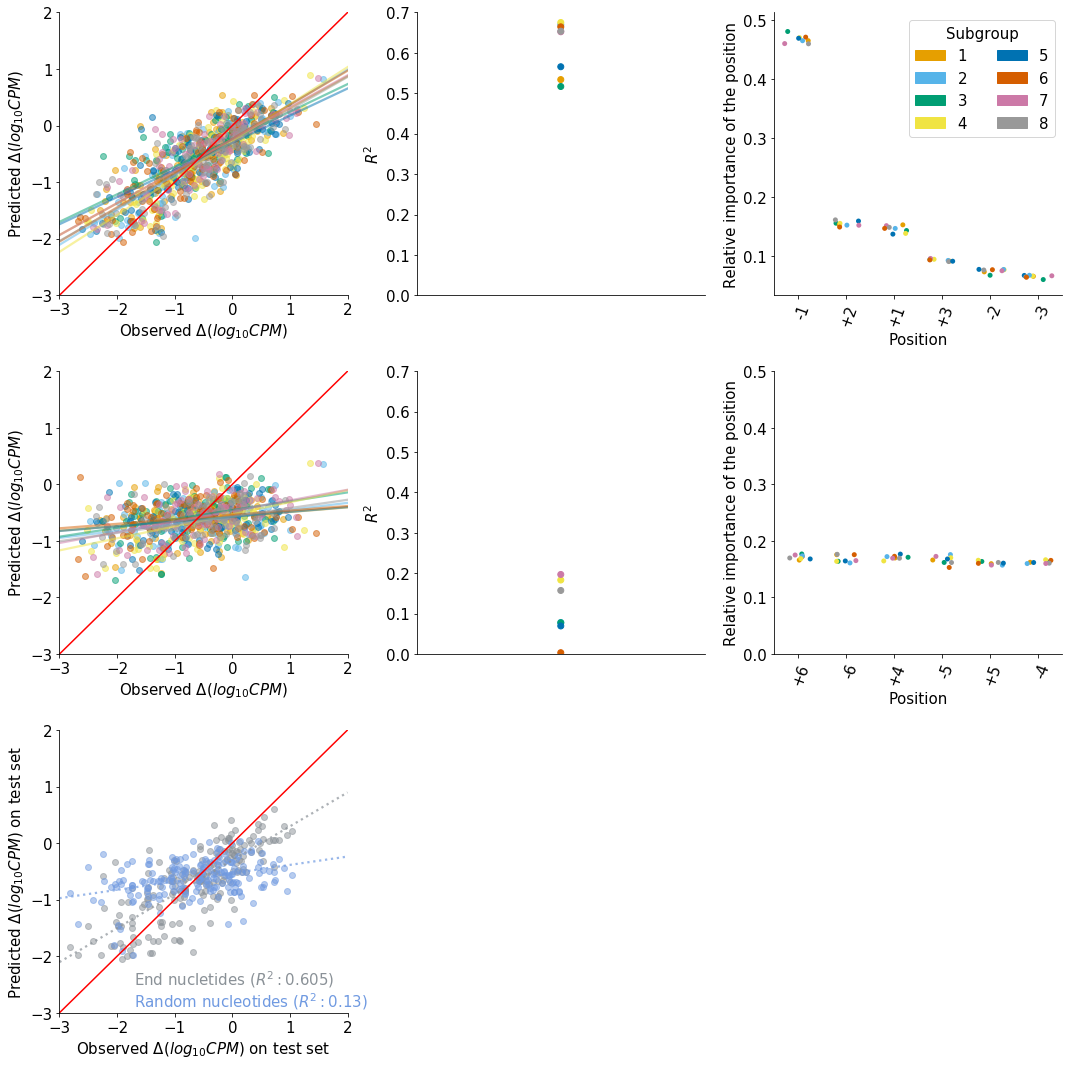

In [8]:
ce = color_encoder()
ce.fit(res_df.k+1)

fig = plt.figure(figsize=(15,15))
# linear plot
ax = fig.add_subplot(331)
plot_kfold_reg(res_df, ax = ax, ce=ce)
ax = fig.add_subplot(334)
plot_kfold_reg(control_res_df, ax = ax, ce=ce)

#R2 plot
ax = fig.add_subplot(332)
r2_df = plot_R2(res_df, ax=ax, ce=ce)
ax.set_ylim(0,0.7)
ax = fig.add_subplot(335)
control_r2_df = plot_R2(control_res_df, ax=ax, ce=ce)
ax.set_ylim(0,0.7)

# var plot
ax = fig.add_subplot(333)
plot_var(var_df, ax=ax, ce=ce, inner=False)
ax = fig.add_subplot(336)
ax.set_ylim(0,0.5)
plot_var(control_var_df, ax=ax, ce=ce, inner=True)
ax.legend().set_visible(False)
ax.set_ylim(0,0.5)

# plot test
ax = fig.add_subplot(337)
plot_test(test_df, control_test_df, ax = ax)

sns.despine()
fig.tight_layout()
figurename = figure_path + '/rf_cv.pdf'
fig.savefig(figurename, bbox_inches='tight')

figurename = figure_path + '/rf_cv.eps'
fig.savefig(figurename, bbox_inches='tight')

# Doing only K-fold CV #

Without test set, 100% data goes into train set CV

In [9]:
res_df, var_df, test_df = k_fold_cv(model_df, model_df)
control_res_df, control_var_df, control_test_df = k_fold_cv(control_model_df, control_test_df)

/Users/wckdouglas/Google_Drive/Lab/projects/miRNA/tgirt_smRNA/scripts/rf_modeling.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  test_df['pred'] = rf.predict(test_df)


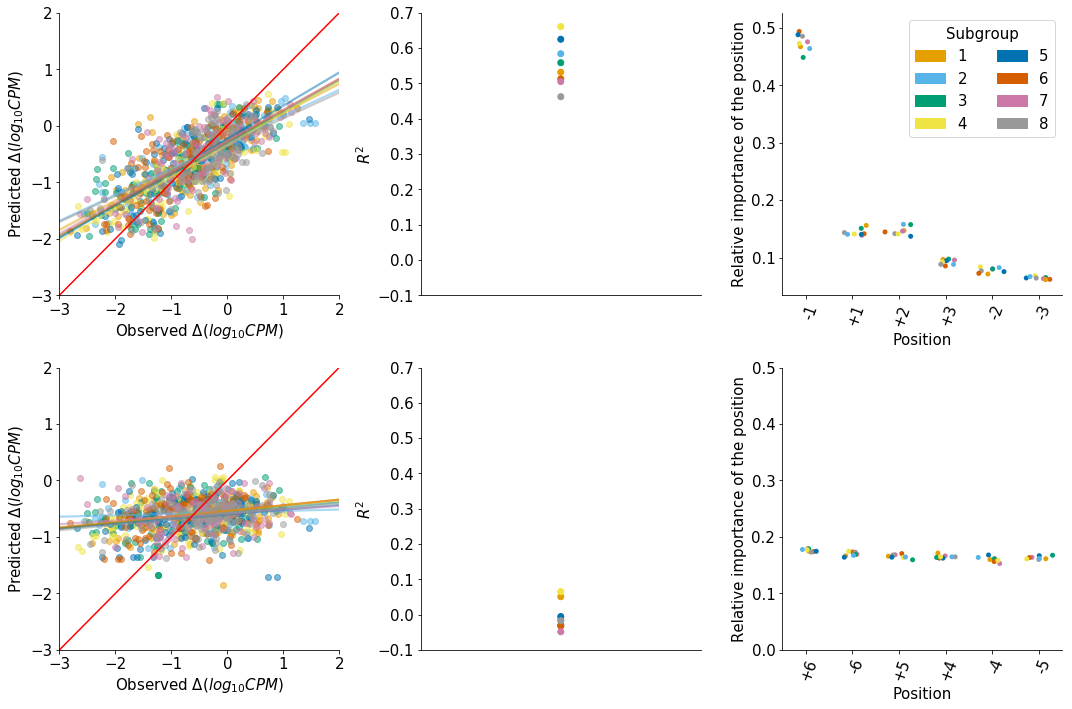

In [10]:
ce = color_encoder()
ce.fit(res_df.k+1)

fig = plt.figure(figsize=(15,10))
# linear plot
ax = fig.add_subplot(231)
plot_kfold_reg(res_df, ax = ax, ce=ce)
ax = fig.add_subplot(234)
plot_kfold_reg(control_res_df, ax = ax, ce=ce)

#R2 plot
ax = fig.add_subplot(232)
r2_df = plot_R2(res_df, ax=ax, ce=ce)
ax.set_ylim(-0.1,0.7)
ax = fig.add_subplot(235)
control_r2_df = plot_R2(control_res_df, ax=ax, ce=ce)
ax.set_ylim(-0.1,0.7)

# var plot
ax = fig.add_subplot(233)
plot_var(var_df, ax=ax, ce=ce, inner=False)
ax = fig.add_subplot(236)
ax.set_ylim(0,0.5)
plot_var(control_var_df, ax=ax, ce=ce, inner=True)
ax.legend().set_visible(False)
ax.set_ylim(0,0.5)



sns.despine()
fig.tight_layout()
figurename = figure_path + '/rf_cv.pdf'
fig.savefig(figurename, bbox_inches='tight')

figurename = figure_path + '/rf_cv.eps'
fig.savefig(figurename, bbox_inches='tight')

In [11]:
r2_df.describe()

,k,r2
count,8.00000,8.000000
mean,3.50000,0.555246
std,2.44949,0.065852
min,0.00000,0.462482
25%,1.75000,0.511083
50%,3.50000,0.545356
75%,5.25000,0.594433
max,7.00000,0.661029


In [12]:
control_r2_df.describe()

,k,r2
count,8.00000,8.000000
mean,3.50000,-0.004263
std,2.44949,0.040647
min,0.00000,-0.048714
25%,1.75000,-0.030854
50%,3.50000,-0.016365
75%,5.25000,0.008523
max,7.00000,0.064975


# Main figure #

Applying PCA on nucleotides from +1 to +3 positions showed that over- and under-representation of miRNAs ($log_{10}$ CPM $> \mu + \sigma$ and $log_{10}$ CPM $< \mu + \sigma$, repsectively) were linearly separable along PC1.

Relative contributions of nucleotides on the bias can be evaluated using loadings on PC1.

Random forest model can be trained to predict over- and under-representation of miRNAs.

In [13]:
random_df = []
t_df = test_nucleotides(nucleotides = [3,4,5, -4,-5,-6])
random_df.append(t_df)
t_df, rf = test_nucleotides(nucleotides=[0,1,2,-3,-2,-1], return_model=True)
random_df.append(t_df)
random_df = pd.concat(random_df)

/Users/wckdouglas/miniconda3/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)
/Users/wckdouglas/Google_Drive/Lab/projects/miRNA/tgirt_smRNA/scripts/rf_modeling.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  d[col] = d[col].astype('category')
/Users/wckdouglas/Google_Drive/Lab/projects/miRNA/tgirt_smRNA/scripts/rf_modeling.py:162: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  test_df['predic

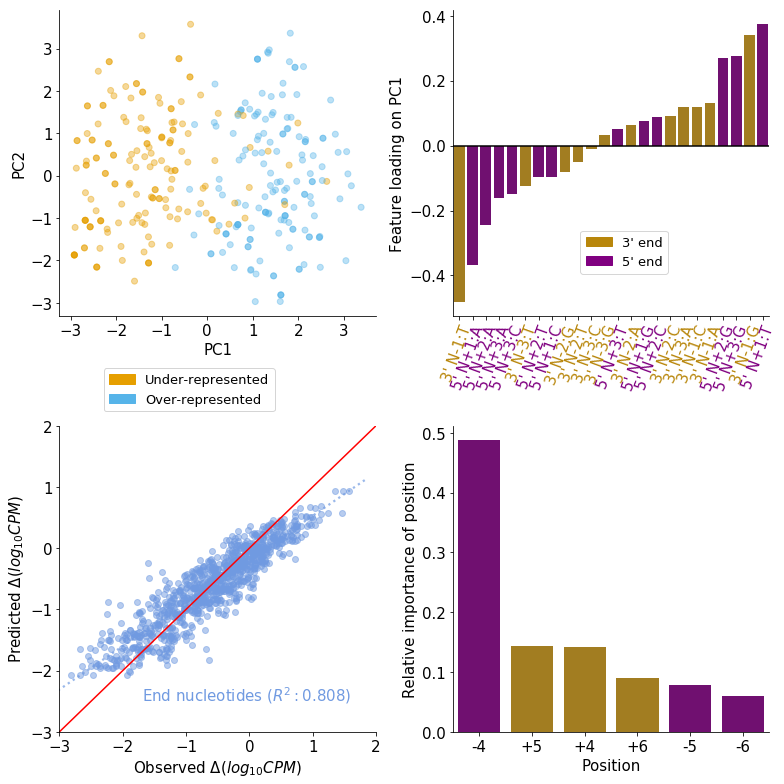

In [14]:
prep_ce = color_encoder()

plot_random_df = random_df \
    .groupby('label', as_index=False)\
    .apply(lambda D: pd.DataFrame({'r2':[r2_score(D.Y, D.predict)], 
                                   'label':[D.label.values[0]]})) \
    .merge(random_df) \
    .assign(label = lambda d: d.label + ' ($R^2: ' + d.r2.round(3).astype(str) + '$)')\
    .assign(colors = lambda d: prep_ce.fit_transform(d.label, simpsons_palette()[1:]))

    
fig = plt.figure(figsize = (11,11))
biplot = fig.add_subplot(221)
pcplot = fig.add_subplot(222)
pca_df = make_pca_df()
pca, pc_df = pca_biplot(pca_df, biplot)
loading_plot(pca_df,pca, pcplot)


ax = fig.add_subplot(223)
for i, ((label, color), lab_df) in enumerate(plot_random_df\
                                             .pipe(lambda d: d[~d.label.str.contains("Random predictors")])\
                                             .groupby(['label', 'colors'])):
    sns.regplot(data = lab_df, 
            ax = ax,
            color = color,
            x = 'Y', 
            y = 'predict', 
            ci = None,
            scatter_kws={'alpha':0.5},
            line_kws = {'linestyle':':', 'alpha':0.7})
    
    ax.text(-1.7, -2.5 - i/2.5, label, fontsize=15, color = color)
ax.plot([-5,3], [-5,3], color='red')
ax.set_xlabel('Observed $\Delta(log_{10} CPM)$')
ax.set_ylabel('Predicted $\Delta(log_{10} CPM)$')
scale = np.arange(-3,3)
ax.set_xticks(scale)
ax.set_yticks(scale)
ax.set_xlim(scale[0], scale[-1])
ax.set_ylim(scale[0], scale[-1])



ax = fig.add_subplot(224)
var_df = rf.coefficients() \
    .sort_values('imp_score', ascending=False)\
    .assign(imp_score = lambda d: d.imp_score/d.imp_score.sum())\
    .assign(x = lambda d: d.variable.map(rename_col))\
    .assign(color = lambda d: np.where(d.x.str.contains('-'), 'purple', 'darkgoldenrod'))
sns.barplot(data = var_df, x = 'x', y = 'imp_score', 
            ax = ax, order = var_df['x'],
            palette = var_df.color.tolist())
ax.legend().set_visible(False)
ax.set_xlabel('Position')
ax.set_ylabel('Relative importance of position')

fig.tight_layout()
sns.despine()
figurename = figure_path + '/rf_control.pdf'
fig.savefig(figurename, bbox_inches='tight')
figurename = figure_path + '/rf_control.eps'
fig.savefig(figurename, bbox_inches='tight')

In [15]:
var_df.groupby('color').agg({'imp_score':'sum'})

,imp_score
color,
darkgoldenrod,0.375129
purple,0.624871


/Users/wckdouglas/miniconda3/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)
/Users/wckdouglas/Google_Drive/Lab/projects/miRNA/tgirt_smRNA/scripts/rf_modeling.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  d[col] = d[col].astype('category')
/Users/wckdouglas/Google_Drive/Lab/projects/miRNA/tgirt_smRNA/scripts/rf_modeling.py:162: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  test_df['predic

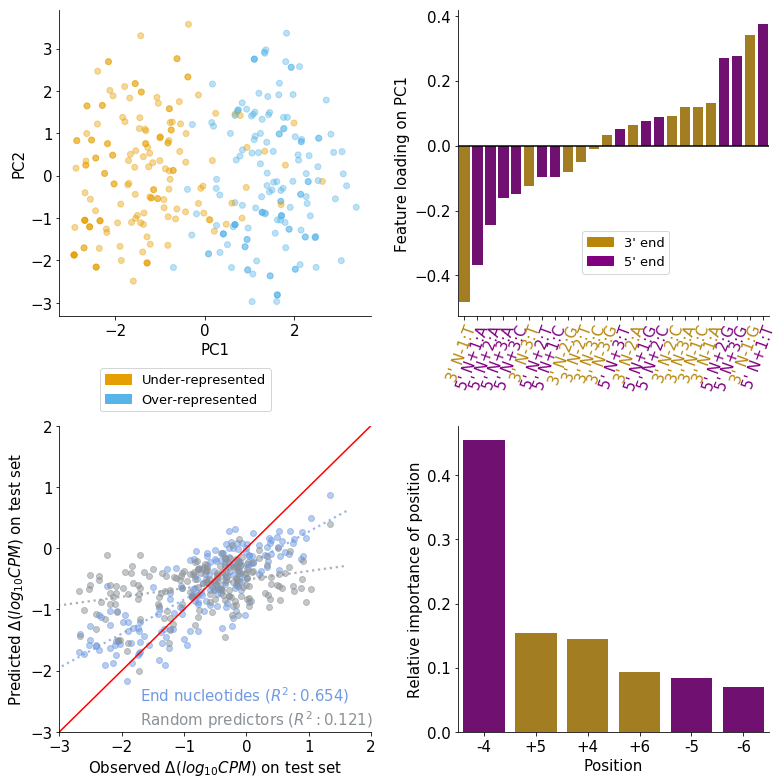

In [16]:
random_df = []
t_df = test_nucleotides(nucleotides = [3,4,5, -4,-5,-6], validation=True)
random_df.append(t_df)
t_df, rf = test_nucleotides(nucleotides=[0,1,2,-3,-2,-1], return_model=True, validation=True)
random_df.append(t_df)
random_df = pd.concat(random_df)


#
plot_random_df = random_df \
    .groupby('label', as_index=False)\
    .apply(lambda D: pd.DataFrame({'r2':[r2_score(D.Y, D.predict)], 
                                   'label':[D.label.values[0]]})) \
    .merge(random_df) \
    .assign(label = lambda d: d.label + ' ($R^2: ' + d.r2.round(3).astype(str) + '$)')\
    .assign(colors = lambda d: prep_ce.fit_transform(d.label, simpsons_palette()[1:]))

    
fig = plt.figure(figsize = (11,11))
biplot = fig.add_subplot(221)
pcplot = fig.add_subplot(222)
pca_df = make_pca_df()
pca, pc_df = pca_biplot(pca_df, biplot)
loading_plot(pca_df,pca, pcplot)


ax = fig.add_subplot(223)
for i, ((label, color), lab_df) in enumerate(plot_random_df.groupby(['label', 'colors'])):
    sns.regplot(data = lab_df, 
            ax = ax,
            color = color,
            x = 'Y', 
            y = 'predict', 
            ci = None,
            scatter_kws={'alpha':0.5},
            line_kws = {'linestyle':':', 'alpha':0.7})
    
    ax.text(-1.7, -2.5 - i/2.5, label, fontsize=15, color = color)
ax.plot([-5,3], [-5,3], color='red')
ax.set_xlabel('Observed $\Delta(log_{10} CPM)$ on test set')
ax.set_ylabel('Predicted $\Delta(log_{10} CPM)$ on test set')
scale = np.arange(-3,3)
ax.set_xticks(scale)
ax.set_yticks(scale)
ax.set_xlim(scale[0], scale[-1])
ax.set_ylim(scale[0], scale[-1])



ax = fig.add_subplot(224)
var_df = rf.coefficients() \
    .sort_values('imp_score', ascending=False)\
    .assign(imp_score = lambda d: d.imp_score/d.imp_score.sum())\
    .assign(x = lambda d: d.variable.map(rename_col))\
    .assign(color = lambda d: np.where(d.x.str.contains('-'), 'purple', 'darkgoldenrod'))
sns.barplot(data = var_df, x = 'x', y = 'imp_score', 
            ax = ax, order = var_df['x'],
            palette = var_df.color.tolist())
ax.legend().set_visible(False)
ax.set_xlabel('Position')
ax.set_ylabel('Relative importance of position')

fig.tight_layout()
sns.despine()

# Corrections #

Training the model on combined NTT dataset, and apply the model on other samples

In [17]:
df = pd.read_feather('../data/miR_count.feather')  \
    .merge(get_seq_base(shuffle = [0,1,2,-3,-2,-1])) 
df.head()

/Users/wckdouglas/miniconda3/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


,index,seq_id,seq_count,samplename,cpm,prep,head0,head1,head2,tail0,tail1,tail2
0,0,EBV-10,128,NTT5_noTA,30.911005,NTT-noTA,T,A,C,T,G,T
1,0,EBV-10,430,MiR_NTM2,41.924719,Diaminopurine,T,A,C,T,G,T
2,0,EBV-10,285,MiR_R3,44.457360,NTC,T,A,C,T,G,T
3,0,EBV-10,1140,MiR_NTTR2,108.568575,NTTR,T,A,C,T,G,T
4,0,EBV-10,254,MiR_NTT2,23.778512,NTT,T,A,C,T,G,T


In [18]:
train_df =  df.groupby(["prep","seq_id"], as_index=False) \
    .agg({'seq_count':'sum'})\
    .merge(get_seq_base(shuffle = [0,1,2,-3,-2,-1]))\
    .assign(cpm = lambda d: d.groupby('prep').seq_count.transform(count_to_cpm))\
    .assign(expected_cpm = lambda d: 1e6 / 962) \
    .assign(Y = lambda d: np.log10(d['cpm']) - np.log10(d['expected_cpm']))  \
    .query('prep == "NTT"')\
    .reset_index() \
    .filter(regex='head|tail|Y') \
    .pipe(train_to_cat)
train_df.head()

,head0,head1,head2,tail0,tail1,tail2,Y
0,T,A,A,G,T,T,-1.946879
1,T,A,T,T,G,A,0.082039
2,A,A,A,A,G,C,-1.150695
3,T,A,A,A,C,A,-0.951889
4,T,A,G,G,T,C,-0.983703


In [19]:
rf.fit(train_df.drop('Y', axis=1), train_df['Y'])

coef_df = train_df\
    .drop('Y', axis=1)\
    .drop_duplicates()
coef_df['predicted'] = rf.predict(coef_df)
coef_df.head()

,head0,head1,head2,tail0,tail1,tail2,predicted
0,T,A,A,G,T,T,-1.665000
1,T,A,T,T,G,A,-0.240606
2,A,A,A,A,G,C,-0.882073
3,T,A,A,A,C,A,-0.858307
4,T,A,G,G,T,C,-0.568880


In [20]:
train_df.shape

(962, 7)

In [21]:
corrected_df = df \
    .merge(coef_df)\
    .assign(log10_cpm = lambda d: np.log10(d.cpm))\
    .assign(pseudocount = lambda d: np.power(10, d.log10_cpm - d.predicted)) \
    .filter(regex='seq|sample|count|prep')\
    .pipe(pd.melt, id_vars = ['seq_id','prep','samplename'], var_name = 'count_type', value_name = 'seq_count') \
    .query('count_type != "seq_count"')\
    .assign(samplename = lambda d: d.samplename + ' (Corrected)')\
    .assign(prep = lambda d: d.prep + ' (Corrected)')\
    .drop('count_type', axis=1) \
    .reset_index()
corrected_df.to_feather('corrected_count.feather')
corrected_df.head()

/Users/wckdouglas/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


,index,seq_id,prep,samplename,seq_count
0,14403,EBV-10,NTT-noTA (Corrected),NTT5_noTA (Corrected),896.654082
1,14404,EBV-10,Diaminopurine (Corrected),MiR_NTM2 (Corrected),1216.135486
2,14405,EBV-10,NTC (Corrected),MiR_R3 (Corrected),1289.601337
3,14406,EBV-10,NTTR (Corrected),MiR_NTTR2 (Corrected),3149.313808
4,14407,EBV-10,NTT (Corrected),MiR_NTT2 (Corrected),689.757578
